# Tutorial on DER Hosting Capacity | <font color=red>Part 4</font>: Monte Carlo Assessment of PV Hosting Capacity of an Integrated MV-LV Network

## 1. Introduction 

### Objectives 
The objectives of this tutorial are:
1. To familiarise with the process by which power engineers can carry out **Monte Carlo-based time-series analyses and determine the PV Hosting Capacity of a given MV-LV distribution network considering uncertainties due to customer demand, customer phase connection, PV generation, and PV location.**

2. To continue familiarising with the advanced tool [OpenDSS](https://www.epri.com/pages/sa/opendss) (using Python and the [dss_python](https://github.com/dss-extensions/dss_python) module). And, to guide you, all will be done using a notebook on [Jupyter Notebook](https://jupyter.org/).

### Structure of this Notebook
The rest of this notebook is divided into three parts:

- **2. Tutorial.** 
     - You will learn, step by step, how to allocate time-varying **Load and PV profiles** to a given integrated MV-LV network with many customers at once. These profiles enable the **time-series analysis** necessary to observe how values (for instance, customer voltages) vary throughout the whole day due to PV (or any other technology).  
     - You will learn how to perform PV Hosting Capacity studies using Monte Carlo-based time series analyses of the integrated MV-LV network.
- **3. Exercises.** Here you will go through some exercises that will help you familiarise with the code and how to modify it for different purposes.
- **4. Simulation Workspace.** Here you can place all your code to run it at once. You should use **`code`** that is relevant to each exercise.

<font color='red'>**<u>Note</u>:**</font> Make sure to understand well how to model the network, particularly how to allocate PV systems and change PV penetrations (2. Tutorial) as this is crucial to go through the exercises. If you make a mistake when modelling the network, your results will be incorrect.

## 2. Tutorial `To BE CHANGED`
### 2.1 Test Circuit and Considerations
The test MV circuit (also known as feeder) used in this tutorial is a real, three-phase MV feeder from Victoria, Australia, owned and operated by **[AusNet Services](https://www.ausnetservices.com.au/)**, who is one of the distribution companies (known as Distribution Network Service Providers [DNSPs] in Australia) in the State of Victoria, Australia.

The time-series active power values of residential load and PV generation used in this tutorial correspond to real, anonymised measurements from smart meters and dedicated PV generation meters that were also provided by **[AusNet Services](https://www.ausnetservices.com.au/)**.

- The MV feeder is one of the multiple feeders supplied by a 2x33MVA, Delta-wye 66kV/22kV primary substation (black triangle), whereas the secondary substations are shown as circles in **Figure 1**. Their transformer rated capacities are represented with the color map.

- The test MV feeder is a real 22kV MV feeder with 79 residential, underground LV networks. Each LV network is supplied by secondary substations with a 22kV/0.433kV distribution transformer.

- Note that although the nominal line-to-line voltage is 400V on the secondary of the transformer, the transformer is actually having a transformation ratio that *boosts* the voltage on the secondary (around 8%). This *boost* is common practice in Australia and other countries around the world. Of course, the off-load tap changes can be used to tune the transformation ratio as needed.

- The topology is shown in **Figure 1**. There are 3374 single-phase residential customers connected through single-phase service cables, and 9 three-phase commercial customers. 

- The residential load dataset contains profiles for 342 customers for a whole year (365 days) in 30-minute intervals. In this particular case, it contains only active power (kW). Consequently, in this tutorial we will be creating the associated reactive power (kvar) profiles.

- The residential PV generation dataset contains daily normalised (from 0 to 1) profiles for a whole year in 30-minute intervals. Given that the sun shines simultaneously to everyone in a small area (such as an LV circuit), for the day being investigated, only one PV generation profile is selected and applied for all the PV systems. However, the actual PV generation depends on the size of each of the PV systems (and any PV inverter function being used).

- Once specific days to be studied are defined, the code randomly allocates profiles of demand to customers. Similarly, once a PV penetration is defined (percentage of customers with a PV system), the code randomly allocates PV systems to customers. However, we use a `seed` to keep the same random list for different PV penetrations.

- Given that the Test LV Circuit has small impedances due to its modern design, **the adopted PV systems are large (with up to 8 kVA inverters). This is simply to demonstrate voltage rise issues**. However, in Australia, it is common for distribution companies to impose a 5kW export limit to single-phase customers. In practice, this means that most installations have inverters of up to 5kVA.

<img style="float: middle;" src="NetworkTopology-CRE21.png" width="35%">

**<center>Figure 1. Network Topology</center>**

### 2.2 Initialisation
#### 2.2.1 Import libraries
Run the code below to import the libraries that will be used in this tutorial.

In [1]:
import os
import numpy as np
import time
from matplotlib import pyplot as plt
import random
import dss

#### 2.2.2 Set the working path
Run the following code to set your working path.   
As an output you get the location in your computer.

In [2]:
mydir = os.getcwd()
print("The files are located in the following path: mydir = %s" %mydir)

The files are located in the following path: mydir = C:\Users\ASIMONOVSKA\Documents\GitHub\Tutorial-DERHostingCapacity-4-MonteCarlo_MV-LV


#### 2.2.3 Set up  dss_engine
Before running the code, we need to set up the dss_engine.

In [3]:
dss_engine = dss.DSS
DSSText = dss_engine.Text                                                      
DSSCircuit = dss_engine.ActiveCircuit                                            
DSSSolution = dss_engine.ActiveCircuit.Solution                                      
ControlQueue = dss_engine.ActiveCircuit.CtrlQueue                                          
dss_engine.AllowForms = 0

### 2.3 Network, Load and DER Modelling
#### 2.3.1  Variable definitions 
- Below is the explanation and the values of the common variables that will be used throughout the tutorial: 
    - `Time_Resolution`, as the name suggests is the time resolution, in this case it is half-hourly (30min).
    - `Num_of_TimeStep`, is the number of timesteps =(24hx60min)/30min. 
    - `Num_of_DisTransformers`, is the number of distribution transformers.
    - `Num_of_HVlines`, is the number of high-voltage lines. 
    - `Inverter_factor`, as the name suggests is the inverter factor.
    - `Voltage_max`, is the maximum value of the voltage in p.u.

<font color='red'>**<u>Note</u>:**</font> All values used in this tutorial will be constant so **you should not change them**.

In [4]:
Time_Resolution = 30 
Num_of_TimeStep = 48
Num_of_DisTransformers = 79
Num_of_HVlines = 649
Inverter_factor = 1.0
Voltage_max = 1.1

#### 2.3.2 Define components
The `Master.txt` file defines the frequency and base voltages, then it redirects to network components definitions: transformers, lines, loads, etc.

In [5]:
DSSText.Command = 'Clear'   
DSSText.Command = 'Compile ' + mydir + '\\Network-CRE21\\Master.txt'
DSSText.Command = 'Set VoltageBases=[66.0, 22.0, 0.400, 0.2309]'
DSSText.Command = 'calcv'  

#### 2.3.3 Import Load and PV profiles
The datasets used in this tutorial are:

- `Residential load data 30-min resolution.npy`: This numpy file contains the load profiles (only active power) for 342 customers for a whole year in 30-minute intervals.
- `Residential PV data 30-min resolution.npy`: This numpy file contains normalised PV generation profiles for a whole year in 30-minute intervals.

In [6]:
houseData30minutes = np.load(mydir + '\\Data House - 30 mins resolution.npy') 
PVData30minutes = np.load(mydir + '\\Data PV - 30 mins resolution.npy')  

#### 2.3.4 Store the *shape* of the Load and PV profiles  
Now that the data has been loaded, let's take a look at the dimensions of the numpy files.  
**Note:** The format of the house data is `(Customers, Days, Readings)` stored in `shape_profiles` and the PV profiles' data is `(Days, Readings)` stored in `PV_shape_profiles` which can be seen by running the code below.

In [7]:
shape_profiles  = houseData30minutes.shape
noProfiles = shape_profiles[0]
PV_shape_profiles  = PVData30minutes.shape

print("The shape of the load profile is:", shape_profiles) 
print("The shape of the PV profiles is:", PV_shape_profiles) 

The shape of the load profile is: (342, 365, 48)
The shape of the PV profiles is: (365, 48)


### 2.4 Installation of PV systems 
When carrying out a Monte Carlo-based time series analyses, we need to make sure that customers' PV systems are only initiliazed **once**, so that we avoid any error messages. 

At the beginning, we initialize **empty PV systems** for all single-phase customers, with installed capacity and maximum power point values equal to zero (`kva=0` and `pmpp=0`).   
Moreover, these PV systems are disabled (`enabled=false`), which means that if a customer does not have a PV system, it will remain **empty** (i.e., `kva=0`,`pmpp=0`) and disabled. 
- Since the PV systems are initialized only for the single-phase customers the code below does the following: 
    - It firstly takes all customers' names.
    - Then, it goes through the list of names and reads the phase of the customer. 
    - If the phase is equal to 1, then it allocates an empty PV system. 

In [8]:
Loadname = DSSCircuit.Loads.AllNames
for iPV_status in range(len(Loadname)):
    DSSCircuit.SetActiveElement('load.' + str(Loadname[iPV_status]))
    phases = int(DSSCircuit.ActiveCktElement.Properties('phases').Val)
    bus1 = DSSCircuit.ActiveCktElement.Properties('bus1').Val
    if phases == 1:
        DSSText.Command = 'new PVSystem.PV_' + str(Loadname[iPV_status])\
                        + ' phases=1'  \
                        + ' irradiance=1' \
                        + ' %cutin=0.05' \
                        + ' %cutout=0.05' \
                        + ' vmaxpu=1.5' \
                        + ' vminpu=0.5' \
                        + ' kva=0' \
                        + ' pmpp=0' \
                        + ' bus1=' + str(bus1) \
                        + ' pf=1' \
                        + ' enabled=false' \
                        + ' kv=0.23' \
                        + ' daily=pvshape1'\
                        + ' VarFollowInverter=True'  

### 2.5 Definition of Functions
#### 2.5.1 def <font color=blue> Function_Load_profile_allocation</font> ()
- For all customers in the given MV-LV network, first the phase is extracted in the variable `phases`.
- The single-phase (residential) customers (phases==1) get a random load_profile from the residential load data `houseData30minutes`.
- The three-phase (commercial) customers (phases==3) get a fixed profile.

In [9]:
def Function_Load_profile_allocation():
    np.random.seed(iRandom)
    for icust, cust in enumerate(Loadname):    
        DSSCircuit.SetActiveElement('load.'+ cust) 
        phases = int(DSSCircuit.ActiveElement.Properties('phases').Val) # store the phase of the customer
        Cust_ran = np.random.randint(len(houseData30minutes))  
        if phases == 1: # residential customers
            DSSCircuit.ActiveElement.Properties('daily').Val='Load_shape_' + str(Cust_ran)    
        else: # commercial customers
            cust_split = cust.split('_')
            Transformername = cust_split[2]
            DSSCircuit.ActiveElement.Properties('daily').Val='Load_shape_Com_' + str(Transformername)

#### 2.5.2 def <font color=blue> Function_PV_Allocation </font> ()
- First, the number of customers with PV systems **PVcustomer_number** `[0, 675, 1350, 2024, 2699, 3374]` corresponds to `[0, 20, 40, 60, 80, 100]`% PV penetration, respectively.
- For PV Penetration different from zero: 
    - A random customer is selected, and a its PV system is enabled. 
    - Since the PV System is enabled, it will get values for the installed capacity and the maximum power point (`kva!=0` and `pmpp!=0`).

<font color='red'>**<u>Note</u>:**</font> Here, inverter control is disabled to improve simulation speed. You can uncomment the inverter part if you want to introduce this feature in your study.

In [10]:
def Function_PV_Allocation():   
    PVcustomer_number=[0, 675, 1350, 2024, 2699, 3374]
    if penetration_list[iPenetration] == 0 :
        global Count, PV_status_dct
        Count = 0
        PV_status_dct = []
        for iPV_status in range(len(PVname)):
            PV_status_dct.append('false')
    else:
        while Count < PVcustomer_number[iPenetration]:
            for iPV_status in range(len(PVname)):
                if PV_status_dct[iPV_status] == 'false':
                    if random.random() < (penetration_list[iPenetration]-penetration_list[iPenetration-1])/(100-penetration_list[iPenetration-1]):
                        PV_status_dct[iPV_status] = 'true'                            
                        DSSCircuit.SetActiveElement('PVSystem.' + str(PVname[iPV_status]))
                        DSSCircuit.ActiveElement.Properties('kva').Val=str(Inverter_factor * PV_allocation[iPV_status])
                        DSSCircuit.ActiveElement.Properties('pmpp').Val=str(PV_allocation[iPV_status])
                        DSSCircuit.ActiveElement.Properties('enabled').Val='true'
                        Count = Count + 1
                        if Count == PVcustomer_number[iPenetration]:
                            break 
                            
#        if iRandom == 0:
#            DSSText.Command = 'New XYCurve.vw_curve'+ str(iPenetration)+' npts=4 Yarray=(1.0, 1.0, 0.2, 0.2) XArray=(0.5, 1.1, 1.13, 2.0)' 
#            DSSText.Command = 'New InvControl.InvPVCtrl'  + str(iPenetration) + ' mode=voltwatt voltwatt_curve=vw_curve'+ str(iPenetration) +' DeltaP_factor=0.05'             
#            DSSText.Command = 'calcv'
#            DSSText.Command = 'set maxcontroliter=1000'
#            DSSText.Command = 'set maxiterations=1000'
#            DSSText.Command = 'calcvoltagebases'         
#            DSSText.Command = 'calcv'

#### 2.5.2 def <font color=blue> Function_iTimeSimulation</font> ()

This is the `main function` that essentially solves the Monte Carlo simulation. 


- At the end of the simulation, the results are stored in the dictionary `Penetration_results_dct`. 
- There are 8 indices under this dictionary which will be used to show the results. 

| Index | Parameter | 
| :------: | :------ | 
| 0 | 100*np.amax(np.array(total_HVT)[:,2])/HV_Trans_Capacity |
| 1 | np.amax(np.array(DisTrans_Uti_Max)) |
| 2 | np.amax(np.array(Line_Utilise_max)) |
| 3 | 100*np.amax(np.array(Non_compliance))/len(Loadname) |
| 4 | np.sum(PV_Curtail) |
| 5 | np.sum(PV_Potential) |
| 6 | np.sum(PV_Potential, axis=0) |
| 7 | np.sum(PV_P, axis=0) |

In [11]:
def Function_iTimeSimulation():
    for iTime in range(Num_of_TimeStep):
        if iTime == 0:
            DisTrans_Uti_Max = [] 
            Line_Utilise_max = []
            Non_compliance = []
            
            NodeName_dct = {}
            LVT_dct = {}
            LNE_dct = {}
            LDE_dct = {}
            
            LDE_bus1 = []
            LDE_bus1_index = []
            LDE_bus_main = []

            all_loads_voltages = []
            
            P_HVT = []
            Q_HVT = []
            S_HVT = []
            total_HVT = []   
                           
            PV_P = []
            PV_Q = []
            PV_Curtail = []
            PV_Potential = []
            PV_Curtail_Percent = []       
    
            all_node_names = DSSCircuit.AllNodeNames
            for iNodes in range(len(all_node_names)):
                NodeName_dct[all_node_names[iNodes]] = iNodes        
            for iTransformer in range(Num_of_DisTransformers):
                LVT_dct['LVT_%s' %iTransformer] = []
            for iLine in range(Num_of_HVlines):
                LNE_dct['LNE_%s' %iLine] = []
            for icust in range(len(Loadname)):
                LDE_dct[Loadname[icust]] = []
                DSSCircuit.SetActiveElement('load.'+Loadname[icust])
                phases = int(DSSCircuit.ActiveCktElement.Properties('phases').Val)
                bus1 = DSSCircuit.ActiveCktElement.Properties('bus1').Val
                LDE_bus_main.append(bus1)
                if phases == 1:
                    LDE_bus1.append(bus1)
                    LDE_bus1_index.append(all_node_names.index(bus1))
                elif phases == 3:
                    LDE_bus1.append(bus1.strip('.1.2.3')+ '.1')
                    LDE_bus1_index.append(all_node_names.index(bus1.strip('.1.2.3')+ '.1'))
                    LDE_bus1.append(bus1.strip('.1.2.3')+ '.2')
                    LDE_bus1_index.append(all_node_names.index(bus1.strip('.1.2.3')+ '.2'))
                    LDE_bus1.append(bus1.strip('.1.2.3')+ '.3')
                    LDE_bus1_index.append(all_node_names.index(bus1.strip('.1.2.3')+ '.3'))  

        
        DSSSolution.Solve()
        
        
        DSSCircuit.SetActiveElement('Transformer.hv_head_tx0')
        HV_Trans_Capacity = float(DSSCircuit.ActiveCktElement.Properties('kVAs').Val.strip('[').strip(']').split(',')[0])
        P_HVT_temp = (DSSCircuit.ActiveCktElement.Powers[0] + DSSCircuit.ActiveCktElement.Powers[2] + DSSCircuit.ActiveCktElement.Powers[4])
        P_HVT.append(P_HVT_temp) 
        Q_HVT_temp = (DSSCircuit.ActiveCktElement.Powers[1] + DSSCircuit.ActiveCktElement.Powers[3] + DSSCircuit.ActiveCktElement.Powers[5])
        Q_HVT.append(Q_HVT_temp)
        S_HVT_temp = np.sqrt(P_HVT_temp**2 + Q_HVT_temp**2)
        S_HVT.append(S_HVT_temp)
        total_HVT.append([P_HVT_temp, Q_HVT_temp, S_HVT_temp])
        
        
        DisTrans_Uti_Max_temp =[]
        for iTransformer in range(Num_of_DisTransformers):
            DSSCircuit.SetActiveElement('transformer.hv_f0_lv%s'%iTransformer + '_tx')    
            number_phases = int(DSSCircuit.ActiveElement.Properties('phases').Val)
            Trans_Capacity = float(DSSCircuit.ActiveCktElement.Properties('kVAs').Val.strip('[').strip(']').split(',')[0])
            if number_phases == 3:
                P1_LVT = DSSCircuit.ActiveCktElement.Powers[0] + DSSCircuit.ActiveCktElement.Powers[2] + DSSCircuit.ActiveCktElement.Powers[4]
                Q1_LVT = DSSCircuit.ActiveCktElement.Powers[1] + DSSCircuit.ActiveCktElement.Powers[3] + DSSCircuit.ActiveCktElement.Powers[5]
                S1_LVT = np.sqrt(P1_LVT**2 + Q1_LVT**2)
                P2_LVT = DSSCircuit.ActiveCktElement.Powers[8] + DSSCircuit.ActiveCktElement.Powers[10] + DSSCircuit.ActiveCktElement.Powers[12]
                Q2_LVT = DSSCircuit.ActiveCktElement.Powers[9] + DSSCircuit.ActiveCktElement.Powers[11] + DSSCircuit.ActiveCktElement.Powers[13]
                S2_LVT = np.sqrt(P2_LVT**2 + Q2_LVT**2)   
            if number_phases == 1:
                P1_LVT = DSSCircuit.ActiveCktElement.Powers[0] + DSSCircuit.ActiveCktElement.Powers[2] + DSSCircuit.ActiveCktElement.Powers[4]
                Q1_LVT = DSSCircuit.ActiveCktElement.Powers[1] + DSSCircuit.ActiveCktElement.Powers[3] + DSSCircuit.ActiveCktElement.Powers[5]
                S1_LVT = np.sqrt(P1_LVT**2 + Q1_LVT**2)
                P2_LVT = DSSCircuit.ActiveCktElement.Powers[6] + DSSCircuit.ActiveCktElement.Powers[8] + DSSCircuit.ActiveCktElement.Powers[10]
                Q2_LVT = DSSCircuit.ActiveCktElement.Powers[7] + DSSCircuit.ActiveCktElement.Powers[9] + DSSCircuit.ActiveCktElement.Powers[11]
                S2_LVT = np.sqrt(P2_LVT**2 + Q2_LVT**2)
            LVT_dct['LVT_%s' %iTransformer].append([P1_LVT, Q1_LVT, S1_LVT, P2_LVT, Q2_LVT, S2_LVT]) 
            DisTrans_Uti_Max_temp.append(100*S1_LVT/Trans_Capacity)
        DisTrans_Uti_Max.append(np.amax(np.array(DisTrans_Uti_Max_temp)))   
        
            
        Line_Utilise_max_temp = []
        for iLine in range(Num_of_HVlines):
            DSSCircuit.SetActiveElement('line.HV_F0_L%s'%iLine)
            I11 = DSSCircuit.ActiveCktElement.CurrentsMagAng[0]
            I12 = DSSCircuit.ActiveCktElement.CurrentsMagAng[2]
            I13 = DSSCircuit.ActiveCktElement.CurrentsMagAng[4]
            NormAmps = DSSCircuit.Lines.NormAmps
            I_sum = I11 + I12 + I13
            I_max = np.maximum(np.array(I11), np.array(I12), np.array(I13))
            LNE_dct['LNE_%s' %iLine].append([I11, I12, I13, NormAmps, 100*I_sum/(NormAmps*3), 100*I_max/NormAmps])
            Line_Utilise_max_temp.append(100*I_max/NormAmps)
        Line_Utilise_max.append(np.amax(np.array(Line_Utilise_max_temp)))


        LDE_temp = np.array(DSSCircuit.AllBusVmagPu)[LDE_bus1_index]
        all_loads_voltages.append(LDE_temp)
        Non_compliance.append(sum(i > Voltage_max for i in LDE_temp))
            

        PV_P_temp = []
        PV_Q_temp = []
        PV_Curtail_temp = []
        PV_Potential_temp = []
        PV_Curtail_Percent_temp = []                    
        PVname = DSSCircuit.PVSystems.AllNames
        if penetration_list[iPenetration]>0:
            for iPV in range(len(PVname)):
                DSSCircuit.SetActiveElement('PVsystem.'+ PVname[iPV])
                iPV_status=DSSCircuit.ActiveCktElement.Properties('enabled').Val
                if iPV_status=='true':
                    PV_size = DSSCircuit.ActiveElement.Properties('Pmpp').Val
                    pvoutput = (np.abs(DSSCircuit.ActiveElement.Powers[0]))
                    pvpotential = float(PV_size) * PV_potential[iTime]
                    pvcurtail = pvpotential - pvoutput
                    if pvcurtail < 0.01:
                        pvcurtail = 0
                    PV_P_temp.append(np.abs(DSSCircuit.ActiveElement.Powers[0]))
                    PV_Q_temp.append(DSSCircuit.ActiveElement.Powers[1])
                    PV_Potential_temp.append(pvpotential)
                    PV_Curtail_temp.append(pvcurtail)
                    PV_Curtail_Percent_temp.append(100*(pvcurtail)/(pvpotential + 0.0001))     
            PV_P.append(PV_P_temp)
            PV_Q.append(PV_Q_temp)
            PV_Potential.append(PV_Potential_temp)
            PV_Curtail.append(PV_Curtail_temp)
            PV_Curtail_Percent.append(PV_Curtail_Percent_temp)
        
    Penetration_results_dct['penetration=%s'%penetration_list[iPenetration]].append \
                            ([100*np.amax(np.array(total_HVT)[:,2])/HV_Trans_Capacity, \
                              np.amax(np.array(DisTrans_Uti_Max)), \
                              np.amax(np.array(Line_Utilise_max)), \
                              100*np.amax(np.array(Non_compliance))/len(Loadname), \
                              np.sum(PV_Curtail), \
                              np.sum(PV_Potential), \
                              np.sum(PV_Potential, axis=0), \
                              np.sum(PV_P, axis=0)])

### 2.6 Simulation and Results
#### 2.6.1 Set number of iterations
After defining the functions, we are ready to run the Monte Carlo analysis. 
- First, we define the number of Monte Carlo iterations.   
  
<font color='red'>**<u>Note</u>:**</font> Without inverter control, each iteration takes around **1-min**, while with inverter control enabled, it gonna take around **10-mins**.

In [12]:
Num_Run = 10

#### 2.6.2 Create results dictionary
The results dictionary is created for each penetration level, and with the tag `penetration`, you are able to look into  particular case for actual outputs.   
<font color='red'>**<u>Note</u>:**</font> You are **not** encouraged to change the penetration list at first,unless you understand the whole code. 

In [13]:
penetration_list = [0, 20, 40, 60, 80, 100]
Penetration_results_dct = {}
for iPenetration in range(len(penetration_list)):
    Penetration_results_dct['penetration=%s'%penetration_list[iPenetration]]= [] 

#### 2.6.3 Run Monte Carlo simulation
A 30-min-resolution Monte Carlo-based analysis is executed for the chosen period and specified penetration level. For each simulation, the load profiles and PV systems are randomly allocated. 

See steps as below:
1. **First randomization on day profile.** Any combination of load profile and PV profile may happen including the worst condition - the day with lowest load and the day with highest PV. Note: It's a season analysis in Southern Summer, during Day 0-62 and Day 335-365.  

2. **Second randomization on load profile allocation.** The method to allocate load profiles was introduced in `Function_Load_profile_allocation`.  

3. **Third randomization on PV system allocation.** For each iteration, the sizes of all PV systems are randomly assigned, and only a part of them are activated according to the penetration level. The method to allocate PV systems was introduced in `Function_PV_Allocation`.

4. Finally, all PV systems are disabled (`enabled=false`), making sure each iteration starts with 0% penetration.

In [14]:
start_time = time.time() 

for iRandom in range(Num_Run):
    np.random.seed(iRandom)
    if np.random.randint(low=0, high=3) == 0:
        Day_Num = np.random.randint(low=335, high=365)
    else:
        Day_Num = np.random.randint(low=0, high=62)
    if np.random.randint(low=0, high=3) == 0:
        Day_Num_PV = np.random.randint(low=335, high=365)
    else:
        Day_Num_PV = np.random.randint(low=0, high=62) 
        
    print('The run number is %s.' %iRandom)
    print('Day number: %s, ' %Day_Num + 'PV Day number: %s.' %Day_Num_PV )
    
    for ii in range(len(houseData30minutes)):
        DSSCircuit.LoadShapes.Name= 'Load_shape_%s'%(ii)
        DSSCircuit.LoadShapes.Pmult=houseData30minutes[ii,Day_Num,:].tolist()  
    DSSCircuit.LoadShapes.Name='pvshape1'
    DSSCircuit.LoadShapes.Pmult=PVData30minutes[Day_Num_PV,:].tolist()    
    PV_potential =  PVData30minutes[Day_Num_PV,:] 

    Function_Load_profile_allocation()

    PV_allocation = [] 
    PVname = DSSCircuit.PVSystems.AllNames
    np.random.seed(iRandom)
    for iPV in range(len(PVname)):
        PV_allocation.append(np.random.choice([2.5,3.5,5.5,8], p=[0.08,0.24,0.52,0.16]))        
    random.seed(iRandom)
    for iPenetration in range(len(penetration_list)):     
        Function_PV_Allocation()
        DSSText.Command = 'Set ControlMode=statatic' 
        DSSText.Command = 'Reset'   
        DSSText.Command = 'Set Mode=daily number=1 stepsize=%s' %Time_Resolution +'m' 
        Function_iTimeSimulation()
        

    for iPV in range(len(PVname)): 
        DSSCircuit.SetActiveElement('PVSystem.'+str(PVname[iPV]))
        DSSCircuit.ActiveElement.Properties('enabled').Val='false'

        
print("Monte Carlo simulation time (in seconds) = ", time.time()-start_time) 

The run number is 0.
Day number: 350, PV Day number: 0.
The run number is 1.
Day number: 43, PV Day number: 343.
The run number is 2.
Day number: 350, PV Day number: 8.
The run number is 3.
Day number: 24, PV Day number: 3.
The run number is 4.
Day number: 46, PV Day number: 1.
The run number is 5.
Day number: 47, PV Day number: 38.
The run number is 6.
Day number: 9, PV Day number: 345.
The run number is 7.
Day number: 360, PV Day number: 3.
The run number is 8.
Day number: 352, PV Day number: 5.
The run number is 9.
Day number: 28, PV Day number: 53.
Monte Carlo simulation time (in seconds) =  355.4012701511383


#### 2.6.4 Plots
By retrieving the results from `Penetration_results_dct`, you can have box plots and assess the network performance from different aspects. Fig.5 and Fig.6 are for PV curtailment, so if you play with the tutorial in a non-inverter control mode, you can only observe no curtailment for granted.  
  
<font color='red'>**<u>Note</u>:**</font> These results are not the most representative ones, because `Num_Run = 10` is not a sufficient number of iterations.  
- We set a small number here to save on the simulation time. The document provided in the same folder [Simulation_results_of_different_Num_Run.docx](Simulation_results_of_different_Num_Run.docx) shows the  results comparison of **10, 30, 100 and 200** iterations. The number of iterations is a key factor for the Monte Carlo-based analyses.

##### 2.6.4.1 **66/22 kV transformer utilization level**

<ipython-input-15-79b60eb98a11>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  S_HVT_Penetration_temp = np.array(Penetration_results_dct['penetration=%s'%penetration_list[iPenetration]])[:,0]


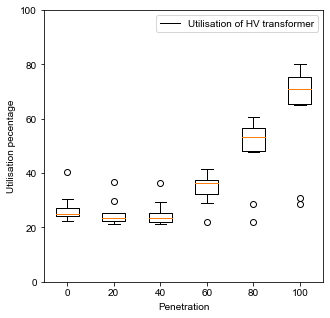

In [15]:
fig = plt.figure(figsize=(5,5))
plt.rc('font', family='Arial')
plt.rc('font', size=10)
plt.rc('figure', figsize=(5,5))
S_HVT_Penetration = []
for iPenetration in range(len(penetration_list)):
    S_HVT_Penetration_temp = np.array(Penetration_results_dct['penetration=%s'%penetration_list[iPenetration]])[:,0]
    S_HVT_Penetration.append(S_HVT_Penetration_temp)
plt.boxplot(S_HVT_Penetration)
plt.ylim([0.00, 100])
plt.legend(['Utilisation of HV transformer'])
plt.ylabel('Utilisation pecentage')
plt.xlabel('Penetration')
plt.xticks([1, 2, 3, 4, 5, 6], ['0', '20', '40', '60', '80', '100',])
plt.show()
plt.close()

##### 2.6.4.2 **Distribution transformer maximum utilization level** 

<ipython-input-16-b856ee980aec>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  S_LVT_Penetration_temp = np.array(Penetration_results_dct['penetration=%s'%penetration_list[iPenetration]])[:,1]


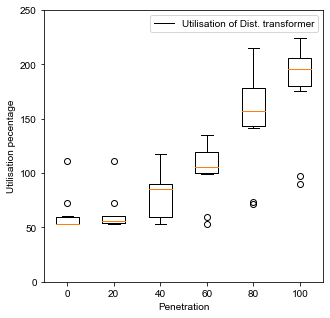

In [16]:
fig = plt.figure(figsize=(5,5))
plt.rc('font', family='Arial')
plt.rc('font', size=10)
plt.rc('figure', figsize=(5,5))
S_LVT_Penetration = []
for iPenetration in range(len(penetration_list)):
    S_LVT_Penetration_temp = np.array(Penetration_results_dct['penetration=%s'%penetration_list[iPenetration]])[:,1]
    S_LVT_Penetration.append(S_LVT_Penetration_temp)
plt.boxplot(S_LVT_Penetration)
plt.ylim([0.00, 250])
plt.legend(['Utilisation of Dist. transformer'])
plt.ylabel('Utilisation pecentage')
plt.xlabel('Penetration')
plt.xticks([1, 2, 3, 4, 5, 6], ['0', '20', '40', '60', '80', '100',])
plt.show()
plt.close()

##### 2.6.4.3 **Utilisation level for 22kV cables**

<ipython-input-17-7560de8e2b61>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Line_Util_Penetration_temp = np.array(Penetration_results_dct['penetration=%s'%penetration_list[iPenetration]])[:,2]


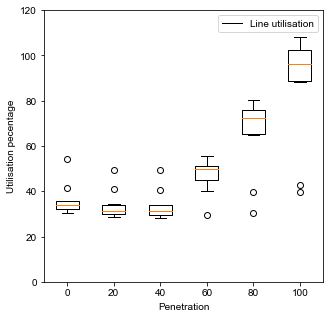

In [17]:
fig = plt.figure(figsize=(5,5))
plt.rc('font', family='Arial')
plt.rc('font', size=10)
plt.rc('figure', figsize=(5,5))
Line_Util_Penetration = []
for iPenetration in range(len(penetration_list)):
    Line_Util_Penetration_temp = np.array(Penetration_results_dct['penetration=%s'%penetration_list[iPenetration]])[:,2]
    Line_Util_Penetration.append(Line_Util_Penetration_temp)
plt.boxplot(Line_Util_Penetration)
plt.ylim([0.00, 120])
plt.legend(['Line utilisation'])
plt.ylabel('Utilisation pecentage')
plt.xlabel('Penetration')
plt.xticks([1, 2, 3, 4, 5, 6], ['0', '20', '40', '60', '80', '100',])
plt.show()
plt.close()

##### 2.6.4.4 **Percentage of customers with voltage issues**

<ipython-input-18-d8a396fef9d4>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Load_nonCompliance_temp = np.array(Penetration_results_dct['penetration=%s'%penetration_list[iPenetration]])[:,3]


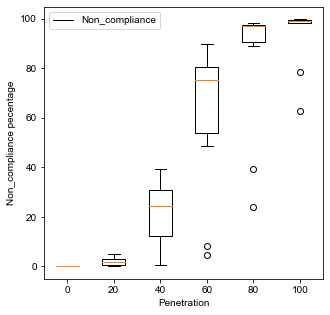

In [18]:
fig = plt.figure(figsize=(5,5))
plt.rc('font', family='Arial')
plt.rc('font', size=10)
plt.rc('figure', figsize=(5,5))
Load_nonCompliance = []
for iPenetration in range(len(penetration_list)):
    Load_nonCompliance_temp = np.array(Penetration_results_dct['penetration=%s'%penetration_list[iPenetration]])[:,3]
    Load_nonCompliance.append(Load_nonCompliance_temp )
plt.boxplot(Load_nonCompliance)
plt.legend(['Non_compliance'])
plt.ylabel('Non_compliance pecentage')
plt.xlabel('Penetration')
plt.xticks([1, 2, 3, 4, 5, 6], ['0', '20', '40', '60', '80', '100',])
plt.show()
plt.close()

##### 2.6.4.5 **PV Curtailed Power in kW**

<ipython-input-19-8337937e1d5b>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  PV_cutail_temp = np.array(Penetration_results_dct['penetration=%s'%penetration_list[iPenetration]])[:,4]


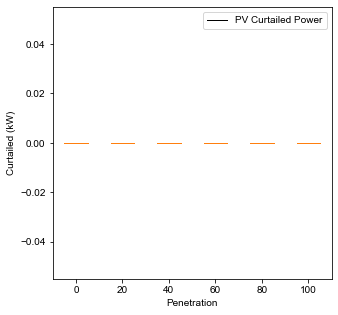

In [19]:
fig = plt.figure(figsize=(5,5))
plt.rc('font', family='Arial')
plt.rc('font', size=10)
plt.rc('figure', figsize=(5,5))
PV_cutail = []
for iPenetration in range(len(penetration_list)):
    PV_cutail_temp = np.array(Penetration_results_dct['penetration=%s'%penetration_list[iPenetration]])[:,4]
    PV_cutail.append(PV_cutail_temp )
plt.boxplot(PV_cutail)
plt.legend(['PV Curtailed Power'])
plt.ylabel('Curtailed (kW)')
plt.xlabel('Penetration')
plt.xticks([1, 2, 3, 4, 5, 6], ['0', '20', '40', '60', '80', '100',])
plt.show()
plt.close()

##### 2.6.4.6 **PV Curtailed Power in Percentage**

<ipython-input-20-c8b262dd9fca>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  PV_percent_temp = 100*np.array(Penetration_results_dct['penetration=%s'%penetration_list[iPenetration]])[:,4] / (1+np.array(Penetration_results_dct['penetration=%s'%penetration_list[iPenetration]])[:,5])


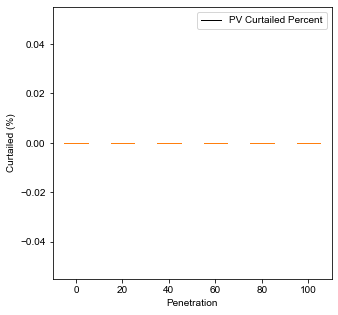

In [20]:
fig = plt.figure(figsize=(5,5))
plt.rc('font', family='Arial')
plt.rc('font', size=10)
plt.rc('figure', figsize=(5,5))
PV_percent = []
for iPenetration in range(len(penetration_list)):
    PV_percent_temp = 100*np.array(Penetration_results_dct['penetration=%s'%penetration_list[iPenetration]])[:,4] / (1+np.array(Penetration_results_dct['penetration=%s'%penetration_list[iPenetration]])[:,5])
    PV_percent.append(PV_percent_temp )
plt.boxplot(PV_percent)
plt.legend(['PV Curtailed Percent'])
plt.ylabel('Curtailed (%)')
plt.xlabel('Penetration')
plt.xticks([1, 2, 3, 4, 5, 6], ['0', '20', '40', '60', '80', '100',])
plt.show()
plt.close()  

## 3. Exercises

First, read all the exercises so you understand their purpose.

At the very end of this notebook in **4. Simulation Workspace**, you will be able to place all your code to run it at once. Remember, you should use **`code`** that is relevant to each exercise.

### **Exercise: PV Hosting Capacity using Monte Carlo-based Analyses using the Test Circuit**

In this exercise, you will use the Test Circuit and assess the PV Hosting Capacity considering inverter control. To achieve this, you will need to **modify the code**, i.e., to uncomment the code in the `def Function_PV_Allocation()` section. 

**E.1:** Since in the [Simulation_results_of_different_Num_Run.docx](Simulation_results_of_different_Num_Run.docx) doc file, the inverter control is not considered, performe the same number of iterations considering the inverter control, i.e:
- **`Num_Run=10`** + `inverter control`
- **`Num_Run=30`** + `inverter control`
- **`Num_Run=100`** + `inverter control`
- **`Num_Run=200`** + `inverter control`

**E.2:** Change the `penetration_list` in **2.6.2** and change the `PVcustomer_number` in **2.5.2** to the values given below, and run again the Monte Carlo analyses for 100 runs, with and without inverter control.  
- **`penetration_list=[0, 30, 60, 90]`** and **`PVcustomer_number=[0, 1012, 2024, 3036]`**



## 4. Simulation Workspace